# Image Classifier (CNN) to detect Pneumonia


In [1]:
import random, os, shutil
import math
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
from fastai.vision.all import *

In [2]:
bs = 64

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

{'test': 586, 'train': 6788, 'val': 1172}


<BarContainer object of 3 artists>

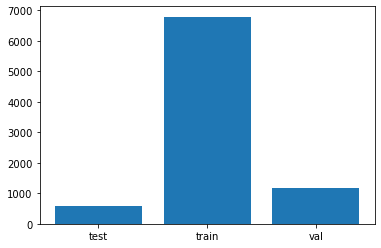

In [4]:
# visualise data segmentation ratio

def count_data_ratio(d):
    data_counts = {}
    for f in os.scandir(d):
        if f.is_dir() and (f.name == 'test' or f.name == 'train' or f.name == 'val'):
            data_counts[f.name] = 0
            for cls in os.scandir(f.path):
                try:
                    files = next(os.walk(cls.path))[2]
                    data_counts[f.name] += len(files)
                except StopIteration:
                    pass
                    

    return data_counts

data_counts = count_data_ratio('./chest_xray/')
print(data_counts)
8546

plt.bar(data_counts.keys(), data_counts.values())

{'NORMAL': 3394, 'PNEUMONIA': 3394}
{'NORMAL': 586, 'PNEUMONIA': 586}
{'NORMAL': 293, 'PNEUMONIA': 293}
Counter({'NORMAL': 4273, 'PNEUMONIA': 4273})


<BarContainer object of 2 artists>

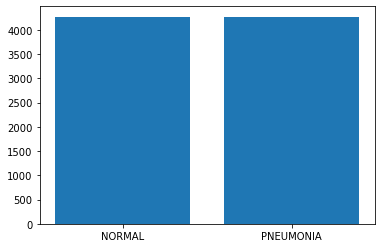

In [5]:
# visualise class distribution

def count_classes_from_folder(d):
    # find all subdirectories (classes)
    class_dict = {}
    for f in os.scandir(d):
        if f.is_dir():
            # get count for each class
            files = next(os.walk(f.path))[2]
            class_dict[f.name] = len(files)
    return class_dict
train_class_dict = count_classes_from_folder('./chest_xray/train')
val_class_dict = count_classes_from_folder('./chest_xray/val')
test_class_dict = count_classes_from_folder('./chest_xray/test')

dicts = [train_class_dict, val_class_dict, test_class_dict]

c = Counter()
for d in dicts:
    c.update(d)
print(train_class_dict)
print(val_class_dict)
print(test_class_dict)
print(c)
    
plt.bar(c.keys(), c.values())


In [ ]:
# due to large class imbalance, we choose to oversample normal images to completely eliminate imbalance 
# (https://www.sciencedirect.com/science/article/abs/pii/S0893608018302107)

# first eliminate all data segmentations and collate all data in /train

def move_from_f_to_d(f, d):
    file_names = os.listdir(f)
    
    for file_name in file_names:
        shutil.move(os.path.join(f, file_name), d)

        
train_normal = './chest_xray/train/NORMAL'
train_pneumonia = './chest_xray/train/PNEUMONIA'
# move_from_f_to_d('./chest_xray/test/NORMAL', train_normal)
# move_from_f_to_d('./chest_xray/test/PNEUMONIA', train_pneumonia)
# move_from_f_to_d('./chest_xray/val/NORMAL', train_normal)
# move_from_f_to_d('./chest_xray/val/PNEUMONIA', train_pneumonia)

classes = count_classes_from_folder('./chest_xray/train')

In [ ]:
# now, to address poor data segmentation, we split the dataset into training, validation & test data
# in a 80:14:6 ratio

def segment_data(n):
    
    # move 20% to val
    num_val = math.ceil(n *0.2)

    normal_path = './chest_xray/train/NORMAL'
    # NORMAL
    for i in range(num_val // 2):
        file_name = random.choice(os.listdir(normal_path))
        shutil.move(os.path.join(normal_path, file_name), './chest_xray/val/NORMAL')

    pneumonia_path = './chest_xray/train/PNEUMONIA'
    # PNEUMONIA
    for i in range(num_val // 2):
        file_name = random.choice(os.listdir(pneumonia_path))
        shutil.move(os.path.join(pneumonia_path, file_name), './chest_xray/val/PNEUMONIA')
    
    
    # move 10% to test
    num_test = math.ceil(n *0.1)
    
    # NORMAL
    for i in range(num_test // 2):
        path = './chest_xray/train/NORMAL'
        file_name = random.choice(os.listdir(normal_path))
        shutil.move(os.path.join(normal_path, file_name), './chest_xray/test/NORMAL')
    
    # PNEUMONIA
    for i in range(num_test // 2):
        file_name = random.choice(os.listdir(pneumonia_path))
        shutil.move(os.path.join(pneumonia_path, file_name), './chest_xray/test/PNEUMONIA')

class_count = count_classes_from_folder('./chest_xray/train')
total = class_count['NORMAL'] + class_count['PNEUMONIA']
# print(total)
# segment_data(total)

In [ ]:
# oversample normal training image data using random seed for reproducibility

def oversample(path, n):
    while n > 0:
        file_name = random.choice(os.listdir(path))

        name, ext = os.path.splitext(file_name)
        duplicate_file_name = "{name}_DUPLICATE{ext}".format(name=name, ext=ext)
        
        if os.path.exists(os.path.join(path, duplicate_file_name)):
            continue
        else:
            shutil.copy2(os.path.join(path, file_name), os.path.join(path, duplicate_file_name))
            n -=1

diff = classes['PNEUMONIA'] - classes["NORMAL"]
# oversample('./chest_xray/train/NORMAL', diff)
    


<BarContainer object of 3 artists>

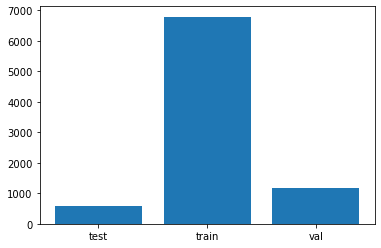

In [6]:
# new balanced, 80:14:6 ratio dataset

data_counts = count_data_ratio('./chest_xray/')
plt.bar(data_counts.keys(), data_counts.values())

In [4]:
path = Path('./chest_xray/');
train_fnames = get_image_files(path/'train')
val_fnames = get_image_files(path/'val')
test_fnames = get_image_files(path/'test')

all_files = get_image_files(path)

L(train_fnames, val_fnames, test_fnames).map(len)

(#3) [6788,1172,586]

In [5]:
# load data
# path = Path('./chest_xray/');
# dls = ImageDataLoaders.from_folder(path, train='train',
#                                    item_tfms=Resize(224),valid_pct=0.2,
#                                    bs=bs,seed=0)

train_idxs = [i for i, fname in enumerate(all_files) if "train" in str(fname)]
val_idxs = [i for i, fname in enumerate(all_files) if "val" in str(fname)]

dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=lambda x: [train_idxs, val_idxs],
                   get_y=parent_label,
                   item_tfms=Resize(224),
                   )

dls = dblock.dataloaders(all_files, bs=bs)


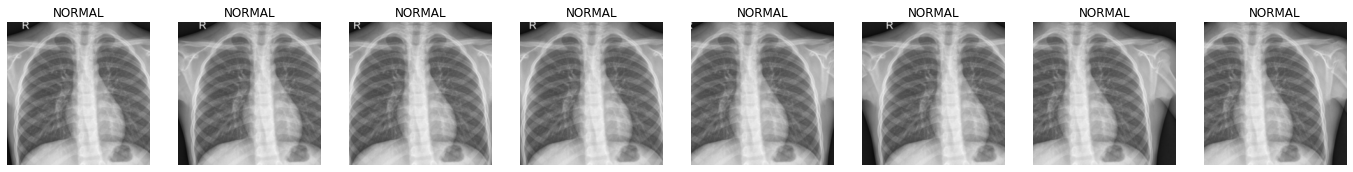

In [9]:
dls.train.show_batch(max_n=8, nrows=1, unique=True)

In [6]:
# verify classes
print(dls.vocab); print(dls.c);

(#2) ['NORMAL','PNEUMONIA']
2


In [7]:
# setup learning architecture using pretrained resnet34
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=6.309573450380412e-07)

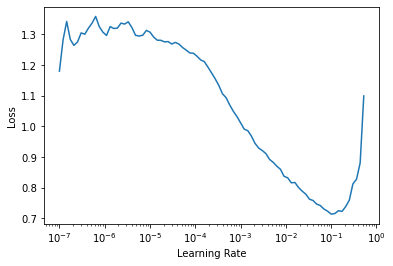

In [8]:
# find optimal learning rate
learn.lr_find()

In [9]:
learn.fit_one_cycle(7, lr_max=1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.229811,0.148777,0.048635,0.951365,00:55
1,0.169641,0.122405,0.040102,0.959898,00:54
2,0.133630,0.202955,0.061433,0.938567,00:54
3,0.078874,0.107325,0.025597,0.974403,00:54
4,0.070644,0.074516,0.025597,0.974403,00:54
5,0.030097,0.078936,0.024744,0.975256,00:54
6,0.015788,0.082193,0.023038,0.976962,00:54


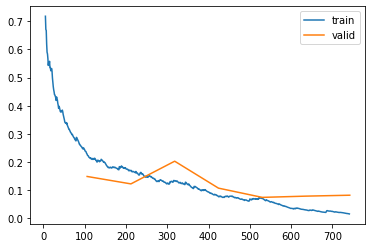

In [10]:
learn.recorder.plot_loss()

In [11]:
# update later resnet layer parameters for pneumonia classification task specifically
learn.unfreeze()

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=7.585775847473997e-07)

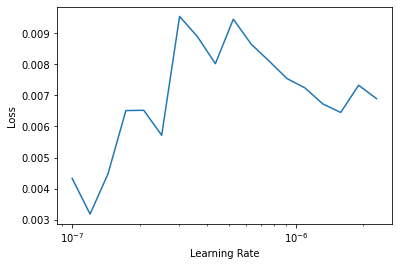

In [12]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(6, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.004718,0.084989,0.019625,0.980375,02:17
1,0.005599,0.156015,0.033276,0.966724,02:18
2,0.010312,0.118902,0.029863,0.970137,02:18
3,0.005189,0.087742,0.020478,0.979522,02:17
4,0.002974,0.080296,0.017918,0.982082,02:17
5,0.001222,0.095075,0.020478,0.979522,02:17


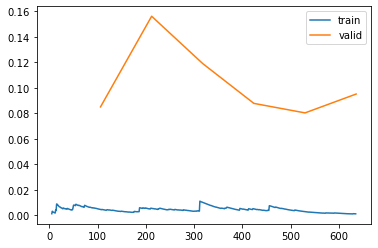

In [13]:
learn.recorder.plot_loss()

In [13]:
# get interpretation of model
interp = ClassificationInterpretation.from_learner(learn)

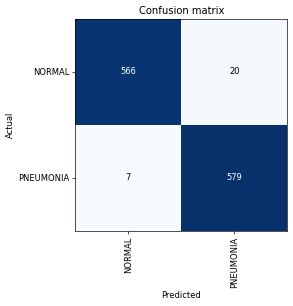

In [14]:
# plot confusion matrix to identify learning outcomes
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)


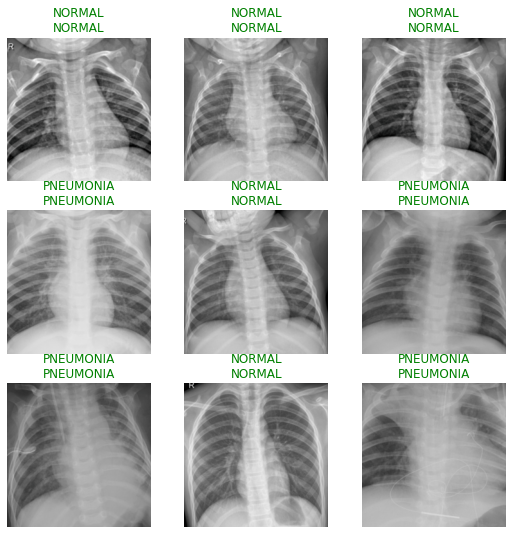

In [15]:
learn.show_results()

In [16]:
# get predictions
preds, _ = learn.get_preds(); preds.shape

torch.Size([1172, 2])

In [17]:
# load test data
test_items = get_image_files(path/'test')

dl = learn.dls.test_dl(test_items, rm_type_tfms=1, bs=64)

In [18]:
# get model predictions for each test image
y_pred, _ = learn.get_preds(dl=dl)
thresh = 0.5
yhat_test = [' '.join([learn.dls.vocab[i] for i,p in enumerate(pred) if p > thresh]) for pred in y_pred.numpy()]

In [19]:
# get test filename for results dataframe
y_test = list(map(lambda x:x.parents[0].name, test_items))

In [20]:
# build prediction results dataframe
results = pd.DataFrame({'target': y_test, 'pred': yhat_test})

In [21]:
# calculate model accuracy for test set
accuracy = results[results.target == results.pred].shape[0]/ results.shape[0]; accuracy

0.9744027303754266